In [33]:
import numpy as np
import pandas as pd
from scipy.stats import norm
import matplotlib.pyplot as plt
from KDEpy import FFTKDE
from scipy.special import kl_div
from scipy.interpolate import interp1d
from scipy.integrate import quad, trapz

In [34]:
plt.style.use('tableau-colorblind10')

SMALL_SIZE = 8
MEDIUM_SIZE = 10
BIGGER_SIZE = 16

plt.rc('font', size=16)          # controls default text sizes
plt.rc('axes', titlesize=16)     # fontsize of the axes title
plt.rc('axes', labelsize=16)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=BIGGER_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=BIGGER_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=BIGGER_SIZE)    # legend fontsize
plt.rc('figure', titlesize=BIGGER_SIZE)  # fontsize of the figure title

In [35]:
path = '../../data/ail_pdr_meta/sneos_meta.txt'
#path = '../../data/ail_pdr_meta/engine2/sneos_meta_e2.txt'

In [36]:
state_names = ["DD2", "SFHo", "SFHx", "BHBlp", "TM1", "NL3"]

In [37]:
raw_data = pd.read_csv(path, sep="|")

In [38]:
raw_data

,ZAMS mass [M_sol],metallicity [],EOS [],outcome [],remnant mass [M_sol],full path
0,11.0,0,1,0,1.408007,/nucastro3/SNEOS/hydro/SFHo/s_series/s11.0_SFHo
1,11.2,0,1,0,1.327998,/nucastro3/SNEOS/hydro/SFHo/s_series/s11.2_SFHo
2,11.4,0,1,0,1.366509,/nucastro3/SNEOS/hydro/SFHo/s_series/s11.4_SFHo
3,11.6,0,1,0,1.377226,/nucastro3/SNEOS/hydro/SFHo/s_series/s11.6_SFHo
4,12.2,0,1,0,1.510838,/nucastro3/SNEOS/hydro/SFHo/s_series/s12.2_SFHo
...,...,...,...,...,...,...
627,40.0,3,0,4,9.575706,/nucastro2/PUSH/paperIV_lowZ/z-series/hydro/R...
628,11.0,3,0,0,1.495512,/nucastro2/PUSH/paperIV_lowZ/z-series/hydro/R...
629,13.0,3,0,0,1.539408,/nucastro2/PUSH/paperIV_lowZ/z-series/hydro/R...
630,14.0,3,0,0,1.593213,/nucastro2/PUSH/paperIV_lowZ/z-series/hydro/R...


In [8]:
raw_data.columns = ['ZAMS_mass', 'metallicity', 'EOS', 'outcome','remnant_mass','full_path']

In [9]:
raw_data.drop('full_path', axis=1, inplace=True)

In [10]:
raw_data.head(5)

,ZAMS_mass,metallicity,EOS,outcome,remnant_mass
0,11.0,0,1,0,1.408007
1,11.2,0,1,0,1.327998
2,11.4,0,1,0,1.366509
3,11.6,0,1,0,1.377226
4,12.2,0,1,0,1.510838


In [11]:
raw_data['EOS'].value_counts()

0    188
1    149
5    128
3    108
2     30
4     29
Name: EOS, dtype: int64

Whether or not the tracer postprocessing script categorized the model as exploding or non-exploding:

- 0 = exploding
- 1 = no explosion
- 2 = black hole formed
- 3 = failed explosion 
- 4 = unclear result. 

Effectively, any value greater than 0 is non-exploding.

In [12]:
raw_data['outcome'].value_counts()

0    509
4     95
2     27
3      1
Name: outcome, dtype: int64

In [13]:
states = sorted(raw_data['EOS'].unique())
print(f"Unique EOS: {states}")

Unique EOS: [0, 1, 2, 3, 4, 5]


In [14]:
def compute_noise(data):
    data['noise'] = 0
    sigma_bh = 0.120213 * data['remnant_mass'] + 0.355936
    sigma_ns = 0.5
    
    # Compute neutron star noise
    ns_mask = (data['outcome'] == 0)
    ns = data[ns_mask]
    data.loc[ns_mask, 'noise'] = pd.Series(np.random.normal(0, sigma_ns, len(ns_mask)))
    
    # Compute black hole noise
    bh_mask = (data['outcome'] != 0)
    bh = data[bh_mask]
    data.loc[bh_mask, 'noise'] = pd.Series(np.random.normal(0, sigma_bh))
    
    data['remnant_mass_noisy'] = data['remnant_mass'] + data['noise']
    data.loc[data['remnant_mass_noisy'] < 0] = 2
    return data

In [15]:
def compute_weights(data):
    m = data_clean['ZAMS_mass'].to_numpy()
    condlist = [m < 0.5, np.logical_and(0.5 <= m, m < 1.0), m >= 1.0]
    funclist = [lambda m: 0.035 * pow(m, -1.3),\
                lambda m: 0.019 * pow(m, -2.2),\
                lambda m: 0.019 * pow(m, -2.7)]
    return np.piecewise(m, condlist, funclist)

In [16]:
def pdf_black_holes(data, c=1.0):
    return data['remnant_mass'].apply(lambda m: c * pow(m, -1.3) * pow(7.9, -1)).to_numpy()

In [17]:
def pdf_neutron_star(data, mu=1.33, sigma=0.09):
    return (1 / (np.sqrt(2 * np.pi * pow(sigma, 2))) * np.exp((-pow(data['remnant_mass'] - mu, 2)) / (2 * pow(sigma, 2))))

In [18]:
x = np.linspace(0, 10, 100)
plt.semilogy(x, s(x, 5, 0))

NameError: name 's' is not defined

In [19]:
def f(mass, delta):
    return (delta / mass) - (delta / (mass - delta))

def s(mass, min_mass, delta):
    x = 1 / (np.exp(f(mass - min_mass, delta)) + 1)
    x[mass <= min_mass] = 0
    x[mass >= (min_mass + delta)] = 1
    return x

def p_bh_2(grid, lmba=0.11, mpp=34.4, spp=1.2):
    a = pow(np.abs(grid), -1.3) * pow(7.9, -1) * s(grid, 5, 0)
    a[grid > 40.8] = 0
    b = np.exp(-(grid-mpp)**2 / (2 * (spp**2))) * s(grid, 5, 0)
    
    norm_a = trapz(a, x=grid)
    a /= norm_a
    
    norm_b = trapz(b, x=grid)
    b /= norm_b
    
    c = (1 - lmba) * a + (lmba * b)
    c /= trapz(c, x=grid)
    return c
    
def p_bh(grid):
    bh_pdf = lambda m: 1.0 * pow(np.abs(m), -1.3) * pow(7.9, -1)
    p_y = bh_pdf(grid)
    p_y[grid < 7.8] = 0
    p_y[grid > 40.8] = 0
    return p_y

def p_nsd(grid):
    p_y = (1 / (np.sqrt(2 * np.pi * pow(0.09, 2))) * 
           np.exp((-pow(grid - 1.33, 2)) / (2 * pow(0.09, 2))))
    return p_y

def p_nsi(grid):
    p_y = (1 / (np.sqrt(2 * np.pi * pow(0.219689, 2))) * 
           np.exp((-pow(grid - 1.54, 2)) / (2 * pow(0.219689, 2))))
    return p_y

def q(data, grid):
    kde = FFTKDE(bw='silverman').fit(data['remnant_mass_noisy'].to_numpy(),
                                     weights=data['weights'].to_numpy())
    y = kde.evaluate(grid)
    return y

def kl_div(data, grid, bh_flag, ns_double):
    if bh_flag:
        p_y = p_bh_2(grid)
    else:
        if ns_double:
            p_y = p_nsd(grid)
        else:
            p_y = p_nsi(grid)
            
    q_y = q(data, grid)
    print(np.any(p_y < 0))
    norm_p = trapz(p_y, x=grid)
    print(norm_p)
    p_y /= norm_p
    flr = max([10 ** -13, min(p_y), min(q_y)])
    p_y[p_y < flr] = flr
    q_y[q_y < flr] = flr
    return p_y, q_y, p_y * np.log2(p_y / q_y)

def tv_dist(data, grid, bh_flag, ns_double):
    if bh_flag:
        p_y, q_y = p_bh_2(grid), q(data, grid)
        norm_p = trapz(p_y, x=grid)
        p_y /= norm_p
        return abs(p_y - q_y)
    else:
        if ns_double:
            p_y, q_y = p_nsd(grid), q(data, grid)
            norm_p = trapz(p_y, x=grid)
            p_y /= norm_p
            return abs(p_y - q_y)
        else:
            p_y, q_y = p_nsi(grid), q(data, grid)
            norm_p = trapz(p_y, x=grid)
            p_y /= norm_p
            return abs(p_y - q_y)

In [20]:
# Compute noise
data_clean = pd.concat([raw_data] * 5000, ignore_index=True)
data_clean = compute_noise(data_clean)
data_clean['weights'] = compute_weights(data_clean)

In [21]:
# Split into states
states_data = []

for state in states:
    states_data.append(data_clean[data_clean['EOS'] == state].reset_index())

In [22]:
# Grid of inputs
grid = np.linspace(data_clean['remnant_mass_noisy'].min() - 1, 
                   data_clean['remnant_mass_noisy'].max() + 1, num=2**15)

In [23]:
# Compute all metrics
black_holes = True
ns_double = False

ps, qs = [], []

for state, data in enumerate(states_data):
    if black_holes and state == 2:
        continue
        
    target = data[data['outcome'] != 0]
    p_y, q_y, kl_val = kl_div(target, grid, black_holes, ns_double)
    d_kl = trapz(kl_val, x=grid)
    print(f"- KL Divergence for EOS {state}: {d_kl:.4f}")

    tv_val = tv_dist(target, grid, black_holes, ns_double)
    d_tv = 0.5 * trapz(tv_val, x=grid)
    print(f"- Total Variation for EOS {state}: {d_tv:.4f}\n")
    
    ps.append(p_y)
    qs.append(q_y)

False
1.0
- KL Divergence for EOS 0: 6.5505
- Total Variation for EOS 0: 0.3978

False
1.0
- KL Divergence for EOS 1: 7.2091
- Total Variation for EOS 1: 0.3864

False
1.0
- KL Divergence for EOS 3: 7.7495
- Total Variation for EOS 3: 0.4950

False
1.0
- KL Divergence for EOS 4: 7.2970
- Total Variation for EOS 4: 0.4290

False
1.0
- KL Divergence for EOS 5: 7.6106
- Total Variation for EOS 5: 0.4508



/home/lambda/anaconda3/envs/sn/lib/python3.8/site-packages/KDEpy/bw_selection.py:260: UserWarning: Silverman's rule currently ignores all weights
  warnings.warn("Silverman's rule currently ignores all weights")
/home/lambda/anaconda3/envs/sn/lib/python3.8/site-packages/KDEpy/bw_selection.py:260: UserWarning: Silverman's rule currently ignores all weights
  warnings.warn("Silverman's rule currently ignores all weights")
/home/lambda/anaconda3/envs/sn/lib/python3.8/site-packages/KDEpy/bw_selection.py:260: UserWarning: Silverman's rule currently ignores all weights
  warnings.warn("Silverman's rule currently ignores all weights")
/home/lambda/anaconda3/envs/sn/lib/python3.8/site-packages/KDEpy/bw_selection.py:260: UserWarning: Silverman's rule currently ignores all weights
  warnings.warn("Silverman's rule currently ignores all weights")
/home/lambda/anaconda3/envs/sn/lib/python3.8/site-packages/KDEpy/bw_selection.py:260: UserWarning: Silverman's rule currently ignores all weights
  warn

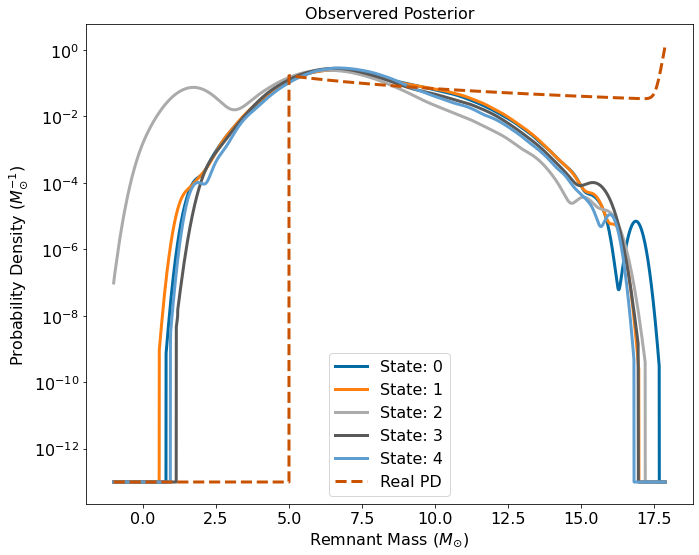

In [24]:
# Obs plots
plt.figure(figsize=(10,8))

for i in range(len(qs)):
    plt.plot(grid, qs[i], lw=3, label=f"State: {i}") #in color

plt.semilogy(grid, ps[0], lw=3, linestyle='--', label="Real PD") #black

plt.title("Observered Posterior")
# plt.xlim(0, 3)
plt.xlabel(r"Remnant Mass ($M_{\odot}$)")
plt.ylabel(r"Probability Density ($M_{\odot}^{-1}$)")
plt.tight_layout(); plt.legend(loc='best')
plt.savefig('uw_kde.png', dpi=350)

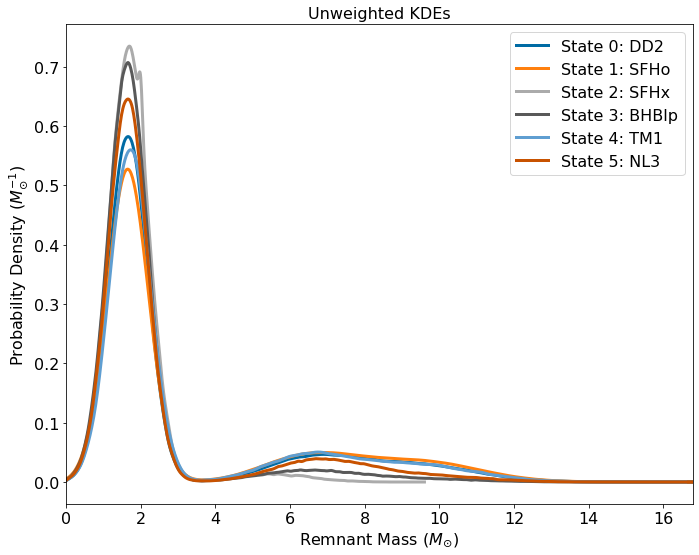

In [25]:
plt.figure(figsize=(10,8))

for state in range(0, 6):
    data = states_data[state]
    target = data['remnant_mass_noisy'].to_numpy()
    x, y = FFTKDE(bw='silverman').fit(target).evaluate()
    plt.plot(x, y, label=f"State {state}: {state_names[state]}", lw=3)

plt.xlim(0, max(x))
plt.title('Unweighted KDEs')
plt.xlabel(r"Remnant Mass ($M_{\odot}$)")
plt.ylabel(r"Probability Density ($M_{\odot}^{-1}$)")
plt.tight_layout(); plt.legend(loc='best')
plt.savefig('uw_kde.png', dpi=350)

/home/lambda/anaconda3/envs/sn/lib/python3.8/site-packages/KDEpy/bw_selection.py:260: UserWarning: Silverman's rule currently ignores all weights
  warnings.warn("Silverman's rule currently ignores all weights")
/home/lambda/anaconda3/envs/sn/lib/python3.8/site-packages/KDEpy/bw_selection.py:260: UserWarning: Silverman's rule currently ignores all weights
  warnings.warn("Silverman's rule currently ignores all weights")
/home/lambda/anaconda3/envs/sn/lib/python3.8/site-packages/KDEpy/bw_selection.py:260: UserWarning: Silverman's rule currently ignores all weights
  warnings.warn("Silverman's rule currently ignores all weights")
/home/lambda/anaconda3/envs/sn/lib/python3.8/site-packages/KDEpy/bw_selection.py:260: UserWarning: Silverman's rule currently ignores all weights
  warnings.warn("Silverman's rule currently ignores all weights")
/home/lambda/anaconda3/envs/sn/lib/python3.8/site-packages/KDEpy/bw_selection.py:260: UserWarning: Silverman's rule currently ignores all weights
  warn

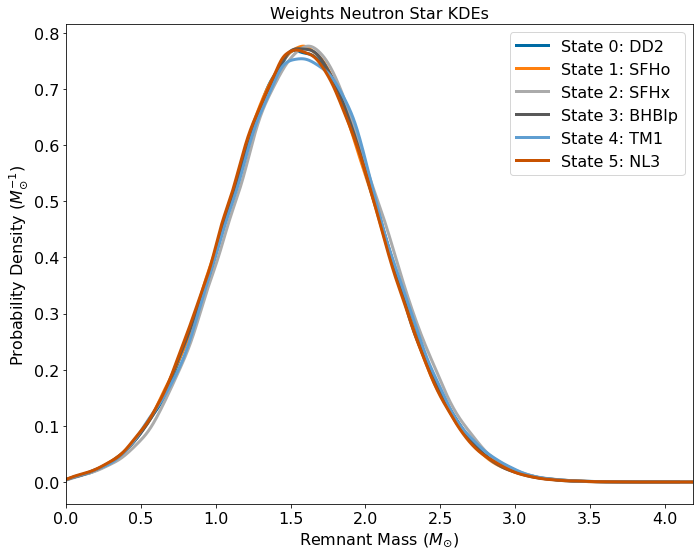

In [26]:
plt.figure(figsize=(10,8))

for state in range(0, 6):
    data = states_data[state]
    ns_data = data[data['outcome'] == 0]
    target = ns_data['remnant_mass_noisy'].to_numpy()
    x, y = FFTKDE(bw='silverman').fit(target, weights=ns_data['weights'].to_numpy()).evaluate()
    plt.plot(x, y, label=f"State {state}: {state_names[state]}", lw=3)
    
plt.xlim(0, max(x))
plt.title('Weights Neutron Star KDEs')
plt.xlabel(r"Remnant Mass ($M_{\odot}$)")
plt.ylabel(r"Probability Density ($M_{\odot}^{-1}$)")
plt.tight_layout(); plt.legend(loc='best')
plt.savefig('w_ns.png', dpi=350)

In [27]:
plt.figure(figsize=(10,8))

for state in range(6):
    if state == 2:
        continue
    data = states_data[state]
    bh_data = data[data['outcome'] != 0]
    target = bh_data['remnant_mass_noisy'].to_numpy()
    kde_ = FFTKDE(bw='silverman')
    kde_.fit(target, weights=bh_data['weights'].to_numpy())
    print(kde_.bw(target.reshape(-1, 1)))
    x, y = kde_.evaluate()
    #x, y = FFTKDE(bw='silverman').fit(target, weights=bh_data['weights'].to_numpy()).evaluate()
    plt.plot(x, y, label=f"State {state}: {state_names[state]}", lw=3)

plt.xlim(0, max(x))
plt.title('Weighted Blackhole KDEs')
plt.xlabel(r"Remnant Mass ($M_{\odot}$)")
plt.ylabel(r"Probability Density ($M_{\odot}^{-1}$)")
plt.tight_layout(); plt.legend(loc='best')
plt.savefig('w_bh.png', dpi=350)

/home/lambda/anaconda3/envs/sn/lib/python3.8/site-packages/KDEpy/bw_selection.py:260: UserWarning: Silverman's rule currently ignores all weights
  warnings.warn("Silverman's rule currently ignores all weights")


TypeError: 'numpy.float64' object is not callable

<Figure size 720x576 with 0 Axes>

In [ ]:
kde_.bw()

In [ ]:
# obs post vs. obs per state
# kl vs. tv
# normalized weights eq 4  
# general plot fixes [done] m_o.

In [ ]:
nsd_kl = [2.8518, 2.8656, 3.8107, 3.1413, 2.7862, 3.6757]
nsd_tv = [0.8236, 0.8244, 0.8857, 0.8449, 0.8781, 0.8179]

nsi_kl = [1.1241, 1.0913, 1.6605, 1.2405, 1.6021, 1.1325]
nsi_tv = [0.5294, 0.5211, 0.6541, 0.5597, 0.6432, 0.5279]

bh_kl = [2.2041, 2.5123, 0, 1.8277, 2.1018, 3.0696]
bh_tv = [0.5427, 0.5575, 0, 0.5629, 0.5306, 0.6594]

In [ ]:
fig, ax = plt.subplots(figsize=(10, 8))
x = np.arange(len(state_names))
width = 0.4
kl_bar = ax.bar(x - width / 2, nsd_kl, 
                label=r"$D_{\mathrm{KL}}$", align='center', width=width)
tv_bar = ax.bar(x + width / 2, nsd_tv, 
                label=r"$D_{\mathrm{TV}}$", align='center', width=width)
ax.set_xticks(x)
ax.set_xticklabels(state_names)
ax.set_title('Distance Metrics (NSD)')
ax.set_xlabel('Equations of State')
ax.set_ylabel('Distance')
fig.tight_layout(); ax.legend(loc='best')
ax.bar_label(kl_bar, padding=3, fmt="%.2f")
ax.bar_label(tv_bar, padding=3, fmt="%.2f")
plt.savefig('barplt_nsd.png', dpi=350)

In [ ]:
fig, ax = plt.subplots(figsize=(10, 8))
x = np.arange(len(state_names))
width = 0.4
kl_bar = ax.bar(x - width / 2, nsi_kl, 
                label=r"$D_{\mathrm{KL}}$", align='center', width=width)
tv_bar = ax.bar(x + width / 2, nsi_tv, 
                label=r"$D_{\mathrm{TV}}$", align='center', width=width)
ax.set_xticks(x)
ax.set_xticklabels(state_names)
ax.set_title('Distance Metrics (NSI)')
ax.set_xlabel('Equations of State')
ax.set_ylabel('Distance')
fig.tight_layout(); ax.legend(loc='best')
ax.bar_label(kl_bar, padding=3, fmt="%.2f")
ax.bar_label(tv_bar, padding=3, fmt="%.2f")
plt.savefig('barplt_nsi.png', dpi=350)

NameError: name 'bh_kl' is not defined

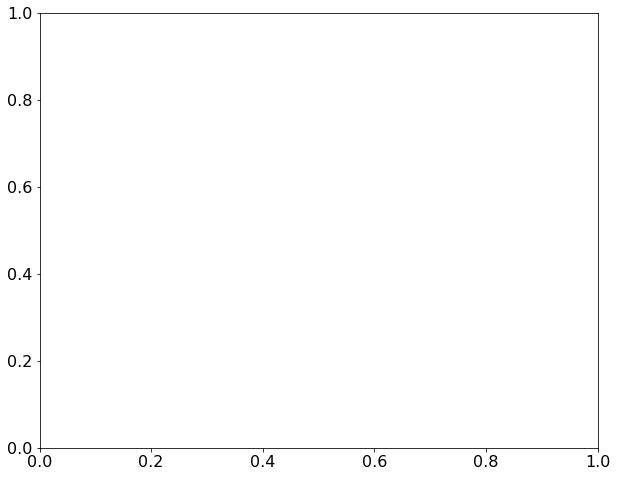

In [28]:
fig, ax = plt.subplots(figsize=(10, 8))
x = np.arange(len(state_names))
width = 0.4
kl_bar = ax.bar(x - width / 2, bh_kl, 
                label=r"$D_{\mathrm{KL}}$", align='center', width=width)
tv_bar = ax.bar(x + width / 2, bh_tv, 
                label=r"$D_{\mathrm{TV}}$", align='center', width=width)
ax.set_xticks(x)
ax.set_xticklabels(state_names)
ax.set_title('Distance Metrics (BH)')
ax.set_xlabel('Equations of State')
ax.set_ylabel('Distance')
fig.tight_layout(); ax.legend(loc='best')
ax.bar_label(kl_bar, padding=3, fmt="%.2f")
ax.bar_label(tv_bar, padding=3, fmt="%.2f")
plt.savefig('barplt_bh.png', dpi=350)

In [ ]:
# # compute dist from avg per metric
# plt.figure(figsize=(10,8))
# plt.bar(state_names, results['nsd']['kl'] - results['nsd']['kl'].mean(), 
#         label=r"($D_{\mathrm{KL}}$)")
# plt.bar(state_names, results['nsd']['tv'] - results['nsd']['kl'].mean(), 
#         label=r"($D_{\mathrm{KL}}$)")
# plt.axhline(y=0, color='black', linestyle='--', alpha=0.5)
# plt.title('Distance from Average (NSD)')
# plt.xlabel("Equataions of State")
# plt.ylabel("Distane (A.U.)")
# plt.legend()
# plt.savefig('dist_avg_nsd.png', dpi=350)

###
fig, ax = plt.subplots(figsize=(10, 8))
width = 0.4
x = np.arange(len(state_names))
avg_dist_kl = results['bh']['kl'] - results['bh']['kl'].mean()
avg_dist_tv = results['bh']['tv'] - results['bh']['tv'].mean()

kl_bar = ax.bar(x - width / 2, avg_dist_kl, 
                label=r"$D_{\mathrm{KL}}$", align='center', width=width)
tv_bar = ax.bar(x + width / 2, avg_dist_tv, 
                label=r"$D_{\mathrm{TV}}$", align='center', width=width)
ax.set_xticks(x)
ax.set_ylim(-1.2, 1.2)
ax.set_xticklabels(state_names)
ax.set_title('Distance to Average (BH)')
ax.set_xlabel('Equations of State')
ax.set_ylabel('Distance')
fig.tight_layout(); ax.legend(loc='best')
ax.bar_label(kl_bar, padding=3, fmt="%.2f")
ax.bar_label(tv_bar, padding=3, fmt="%.2f")
ax.axhline(y=0, color='black', linestyle='--', alpha=0.5)
plt.savefig('dist_avg_bh.png', dpi=350)

In [ ]:
# # compute dist from avg per metric
# plt.figure(figsize=(10,8))
# plt.bar(state_names, results['nsd']['kl'] - results['nsd']['kl'].mean(), 
#         label=r"($D_{\mathrm{KL}}$)")
# plt.bar(state_names, results['nsd']['tv'] - results['nsd']['kl'].mean(), 
#         label=r"($D_{\mathrm{KL}}$)")
# plt.axhline(y=0, color='black', linestyle='--', alpha=0.5)
# plt.title('Distance from Average (NSD)')
# plt.xlabel("Equataions of State")
# plt.ylabel("Distane (A.U.)")
# plt.legend()
# plt.savefig('dist_avg_nsd.png', dpi=350)

###
fig, ax = plt.subplots(figsize=(10, 8))
width = 0.4
x = np.arange(len(state_names))
avg_dist_kl = results['nsi']['kl'] - results['nsi']['kl'].mean()
avg_dist_tv = results['nsi']['tv'] - results['nsi']['tv'].mean()

kl_bar = ax.bar(x - width / 2, avg_dist_kl, 
                label=r"$D_{\mathrm{KL}}$", align='center', width=width)
tv_bar = ax.bar(x + width / 2, avg_dist_tv, 
                label=r"$D_{\mathrm{TV}}$", align='center', width=width)
ax.set_xticks(x)
# ax.set_ylim(-1.2, 1.2)
ax.set_xticklabels(state_names)
ax.set_title('Distance to Average(NSI)')
ax.set_xlabel('Equations of State')
ax.set_ylabel('Distance')
fig.tight_layout(); ax.legend(loc='best')
ax.bar_label(kl_bar, padding=3, fmt="%.2f")
ax.bar_label(tv_bar, padding=3, fmt="%.2f")
ax.axhline(y=0, color='black', linestyle='--', alpha=0.5)
plt.savefig('dist_avg_nsi.png', dpi=350)

In [ ]:
# # compute dist from avg per metric
# plt.figure(figsize=(10,8))
# plt.bar(state_names, results['nsd']['kl'] - results['nsd']['kl'].mean(), 
#         label=r"($D_{\mathrm{KL}}$)")
# plt.bar(state_names, results['nsd']['tv'] - results['nsd']['kl'].mean(), 
#         label=r"($D_{\mathrm{KL}}$)")
# plt.axhline(y=0, color='black', linestyle='--', alpha=0.5)
# plt.title('Distance from Average (NSD)')
# plt.xlabel("Equataions of State")
# plt.ylabel("Distane (A.U.)")
# plt.legend()
# plt.savefig('dist_avg_nsd.png', dpi=350)

###
fig, ax = plt.subplots(figsize=(10, 8))
width = 0.4
x = np.arange(len(state_names))
avg_dist_kl = results['nsd']['kl'] - results['nsd']['kl'].mean()
avg_dist_tv = results['nsd']['tv'] - results['nsd']['tv'].mean()

kl_bar = ax.bar(x - width / 2, avg_dist_kl, 
                label=r"$D_{\mathrm{KL}}$", align='center', width=width)
tv_bar = ax.bar(x + width / 2, avg_dist_tv, 
                label=r"$D_{\mathrm{TV}}$", align='center', width=width)
ax.set_xticks(x)
# ax.set_ylim(-1.2, 1.2)
ax.set_xticklabels(state_names)
ax.set_title('Distance to Average(NSD)')
ax.set_xlabel('Equations of State')
ax.set_ylabel('Distance')
fig.tight_layout(); ax.legend(loc='best')
ax.bar_label(kl_bar, padding=3, fmt="%.2f")
ax.bar_label(tv_bar, padding=3, fmt="%.2f")
ax.axhline(y=0, color='black', linestyle='--', alpha=0.5)
plt.savefig('dist_avg_nsd.png', dpi=350)

In [ ]:
z = data_clean['ZAMS_mass'].to_numpy()
w = data_clean['weights'].to_numpy()
idx = np.argsort(z)
z = z[idx]
w = w[idx]

In [ ]:
plt.figure(figsize=(10,8))
plt.semilogy(z, w, lw=4, c="seagreen")
plt.title('Normalized Weights')
plt.xlabel(r"Zero Age Main Sequence Mass ($M_{\odot}$)")
plt.ylabel(r"Probability Density ($M_{\odot}^{-1}$)")
plt.savefig('weights.png', dpi=350)